In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from model import Model, CustomDataset
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import imageio
from tqdm import tqdm

In [2]:
torch.random.seed()

976559221640899275

In [3]:
import gymnasium as gym
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, _ = env.reset()
print(obs)
obs = np.append(obs, 0.98198156248)
print(obs)
type(obs)

[-0.04900596  0.04067098  0.01574551 -0.03878015]
[-0.04900596  0.04067098  0.01574551 -0.03878015  0.98198156]


numpy.ndarray

In [4]:
class CartPoleAgent:
    def __init__(self, epsilon = 0.001, gamma=0.99) -> None:
        self.target_network = torch.load(f"epoch_50_model.pth")
        self.online_network = self.target_network
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = pow(100*self.epsilon, 0.04)
    def evaluate(self, iter) -> None:
        env = gym.make("CartPole-v1", render_mode="rgb_array")
        avg_reward = total_error = 0
        for cnt in range(1):
            obs, _ = env.reset()
            done = False
            images = []
            Q_s_0, Q_s_1 = self.online_network(x=np.append(obs, 0).reshape(1,-1)).cpu().detach().item(), self.online_network(x=np.append(obs, 1)).cpu().detach().item()
            epi_reward = 0
            while not done:
                action = int(Q_s_0 < Q_s_1)
                obs, reward, done, info, _ = env.step(action=action)
                Q_s_0_new, Q_s_1_new = self.online_network(x=np.append(obs, 0).reshape(1,-1)).cpu().detach().item(), self.online_network(x=np.append(obs, 1)).cpu().detach().item()
                total_error += (reward + self.gamma * max(Q_s_0_new, Q_s_1_new) - max(Q_s_0, Q_s_1))**2
                img = env.render()
                images.append(img)
                avg_reward += 1
                Q_s_0 = Q_s_0_new
                Q_s_1 = Q_s_1_new
                epi_reward += 1
                if epi_reward > 500:
                    break
            imageio.mimsave(f"./gifs/iter_{iter}.gif", images, duration=1)
        print(f"Average reward after {iter} iterations : {avg_reward/1}, with average error of : {total_error/avg_reward}")
        return total_error/avg_reward
    def choose_action(self, Q_s) -> int:
        if not isinstance(Q_s, np.ndarray):
            Q_s = np.array(Q_s)
        if np.random.random()<self.epsilon:
            return np.random.choice(2, size=1)[0]
        else:
            return np.argmax(Q_s)
    def _generate_training_data(self):
        replay_buffer_data = np.empty((0,5))
        replay_buffer_labels = np.empty((0, 1))
        env = gym.make("CartPole-v1", render_mode="rgb_array")
        num_episodes = 20
        for episode_no in range(num_episodes):
            obs, _ = env.reset()
            obs = np.array(obs, dtype=np.float32)
            done = False
            Q_s_0, Q_s_1 = self.online_network(x=np.append(obs, 0).reshape(1,-1)).cpu().detach().item(), self.online_network(x=np.append(obs, 1)).cpu().detach().item()
            cnt = 0
            while not done:
                action = self.choose_action([Q_s_0, Q_s_1])
                new_obs, reward, done, info, _ = env.step(action=action)
                new_obs = np.array(new_obs, dtype=np.float32)
                Q_s_0, Q_s_1 = self.online_network(x=np.append(obs, 0)).cpu().detach().item(), self.online_network(x=np.append(obs, 1)).cpu().detach().item()
                best_new_action = int(Q_s_0 < Q_s_1)
                replay_buffer_data = np.append(replay_buffer_data, np.append(obs, action).reshape(1,5), axis=0)
                target = reward + self.gamma * int(not done) * self.target_network.forward(x=np.append(new_obs, best_new_action)).cpu().detach().item()
                replay_buffer_labels = np.append(replay_buffer_labels, target)
                obs = new_obs
                cnt += 1
                if cnt>500:
                    break
            # if replay_buffer_data.shape[0]>:
            #    break
        return replay_buffer_data, replay_buffer_labels
    def _train(self):
        epochs = 25
        errors = []
        for epoch in range(50,50+epochs):
            replay_buffer_data, replay_buffer_labels = self._generate_training_data()
            train_dataset = CustomDataset(replay_buffer_data, replay_buffer_labels)
            self.online_network._train__instance__(train_dataset=train_dataset)
            self.online_network._save__model__(str(epoch))
            del self.target_network
            del replay_buffer_data
            del replay_buffer_labels
            self.target_network = torch.load(f"epoch_{epoch}_model.pth")
            print("Model Updated and saved!")
            errors.append(self.evaluate(epoch+1))
            self.epsilon = self.epsilon / self.decay
        plt.plot(errors)
        plt.show()

Epoch 1/10, Loss: 0.021019013555138747
Epoch 2/10, Loss: 0.9484314369428167
Epoch 3/10, Loss: 1.8541268254166834
Epoch 4/10, Loss: 0.01749547207652497
Epoch 5/10, Loss: 0.01369533451012713
Epoch 6/10, Loss: 0.9171323488205099
Epoch 7/10, Loss: 0.9223018505069376
Epoch 8/10, Loss: 0.01072267456360234
Epoch 9/10, Loss: 0.013366299241085514
Epoch 10/10, Loss: 0.013480774435467928
Model Updated and saved!
Average reward after 51 iterations : 126.0, with average error of : 0.3328163069570711
Epoch 1/10, Loss: 3.0297031909203187
Epoch 2/10, Loss: 2.2130457814948024
Epoch 3/10, Loss: 0.8886801663066044
Epoch 4/10, Loss: 0.9604733749305435
Epoch 5/10, Loss: 2.3507227829291013
Epoch 6/10, Loss: 1.9135211764325248
Epoch 7/10, Loss: 0.6035999677012135
Epoch 8/10, Loss: 5.653936378575236
Epoch 9/10, Loss: 5.4457137372118805
Epoch 10/10, Loss: 4.371506272766929
Model Updated and saved!
Average reward after 52 iterations : 254.0, with average error of : 0.9939615100005346
Epoch 1/10, Loss: 0.0203286

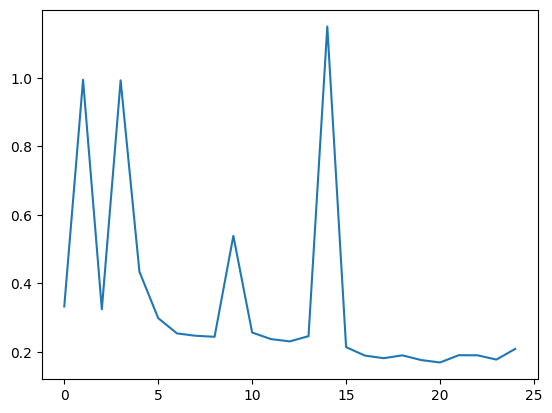

In [5]:
obj1 = CartPoleAgent()
obj1._train()